In [1]:
### Import libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy 
import re
import os
import sys 
import matplotlib.dates
# import sqlite3
# import sqlalchemy

# import warnings
from datetime import datetime
from tabulate import tabulate



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline

In [0]:
MY_PATH = "drive/My Drive/github/erdos_project/"

In [0]:
# df = pd.read_excel(MY_PATH+"Acme.xlsx", index_col=0)
df = pd.read_csv(MY_PATH+"clean.csv", index_col=0)

In [0]:
# df['currently_insured'] = df['currently_insured'].replace({'Y':1, 'N':0})
# df['married'] = df['marital_status'].replace({'M':1, 'S':0})
# df = df.drop(columns=['marital_status', 'cost'])

In [5]:
df.head()

,click,currently_insured,number_of_vehicles,number_of_drivers,rank,policies sold,married
impression_id,,,,,,,
1,1,0,1,1,1,1,1
2,0,0,2,1,4,0,1
3,0,0,1,1,2,0,0
4,0,1,2,1,5,0,1
5,0,1,2,2,4,0,0


In [0]:
print(df.number_of_drivers.unique(),df.number_of_vehicles.unique())

[1 2] [1 2]


In [0]:
g1 = df[['currently_insured','number_of_drivers','number_of_vehicles','rank']]\
    .groupby(['currently_insured','number_of_drivers','number_of_vehicles','rank'])\
    .size().unstack(fill_value=0)
g2 = df[['currently_insured','number_of_drivers','number_of_vehicles']]\
    .groupby(['currently_insured','number_of_drivers','number_of_vehicles']).size()
rename_dict = {0:'TotalNum'}
for r in range(1,6): 
  rename_dict[r] = 'Rank'+str(r)
df_rank_sum = pd.concat([g1,g2], axis=1).rename(columns=rename_dict)

In [28]:
df_rank_sum

Rank1  ...  TotalNum
currently_insured number_of_drivers number_of_vehicles         ...          
0                 1                 1                     164  ...       785
                                    2                       0  ...      2124
                  2                 1                     593  ...      1178
                                    2                       0  ...       921
1                 1                 1                     165  ...       773
                                    2                       0  ...      2149
                  2                 1                     210  ...      1181
                                    2                       0  ...       889

[8 rows x 6 columns]

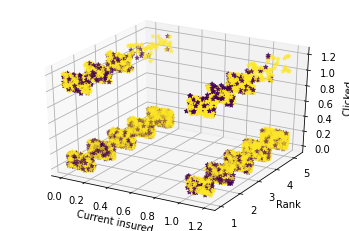

In [0]:
# Visualize 3d clusters 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
RAND_RANGE = .2
x = np.array(df['currently_insured'])+np.random.uniform(0,RAND_RANGE,10000)
y = np.array(df['rank'])+np.random.uniform(0,RAND_RANGE,10000)
z = np.array(df['click'])+np.random.uniform(0,RAND_RANGE,10000)

ax.scatter(x, y, z, c=df['married'], marker='*')
ax.set_xlabel('Current insured')
ax.set_ylabel('Rank')
ax.set_zlabel('Clicked')

plt.show()

From here, we see that we are doing signigicantly worse in the category with ```currently_insured==1, number_of_drivers==2, number_of_vehicles==1```.
Question: is this category profitable? 

## Question: Does probability of clicking depend on viewer's insurance status, num_of_drivers, num_of_vehicles?

In [0]:
df[['currently_insured','number_of_drivers','number_of_vehicles','click']].groupby(['currently_insured','number_of_drivers','number_of_vehicles']).mean()

click
currently_insured number_of_drivers number_of_vehicles          
0                 1                 1                   0.216561
                                    2                   0.053202
                  2                 1                   0.333616
                                    2                   0.090119
1                 1                 1                   0.203105
                                    2                   0.054909
                  2                 1                   0.216765
                                    2                   0.094488

It appears that people with only 1 vehicle is more likely to click on our ad. Let's test this hypothesis controlling for rank etc. 

In [0]:
for r in range(1,6): 
  d0 = df[(df['rank']==r) & (df['number_of_vehicles']==1)]['click']
  d1 = df[(df['rank']==r) & (df['number_of_vehicles']==2)]['click']
  t_test_result = scipy.stats.ttest_ind(d0,d1, equal_var = False)
  t_stat = t_test_result[0]
  p_val = t_test_result[1]
  print("When we rank {}, p val is {}.".format(r,p_val))

When we rank 1, p val is nan.
When we rank 2, p val is 0.8542085992341869.
When we rank 3, p val is 0.6834419198349218.
When we rank 4, p val is 0.5180143827757095.
When we rank 5, p val is nan.


In [36]:
df.loc[(df['married']==0) & (df['number_of_drivers']==2) & (df['number_of_vehicles']==2) & (df['policies sold']==1)]

,click,currently_insured,number_of_vehicles,number_of_drivers,rank,policies sold,married
impression_id,,,,,,,
373,1,0,2,2,4,1,0
407,1,0,2,2,2,1,0
1542,1,0,2,2,3,1,0
1771,1,1,2,2,4,1,0
2139,1,0,2,2,5,1,0
3058,1,0,2,2,2,1,0
3213,1,0,2,2,3,1,0
3432,1,1,2,2,3,1,0
3837,1,1,2,2,2,1,0


Interesting, we got some nan. Apparently the difference is due to our rank, rather than how many cars a person owns. 

In [0]:
g1 = df.groupby(['rank','currently_insured','number_of_drivers','number_of_vehicles','married']).mean()
g2 = df.groupby(['rank','currently_insured','number_of_drivers','number_of_vehicles','married']).size()#.unstack(fill_value=0)
# g2 = df[['currently_insured','number_of_drivers','number_of_vehicles','married']]\
#     .groupby(['currently_insured','number_of_drivers','number_of_vehicles']).size()
# rename_dict = {0:'TotalNum'}
# for r in range(1,6): 
#   rename_dict[r] = 'Rank'+str(r)
# df_rank_sum = pd.concat([g1,g2], axis=1).rename(columns=rename_dict)

In [0]:
pd.concat([g1,g2], axis=1)

click  ...     0
rank currently_insured number_of_drivers number_of_vehicles married            ...      
1    0                 1                 1                  0        0.571429  ...     7
                                                            1        0.509554  ...   157
                       2                 1                  0        0.514184  ...   282
                                                            1        0.488746  ...   311
     1                 1                 1                  0        0.636364  ...    11
                                                            1        0.500000  ...   154
                       2                 1                  0        0.523364  ...   107
                                                            1        0.582524  ...   103
2    0                 1                 1                  0        0.200000  ...    10
                                                            1        0.215385  ...   195
                       2                 1                  0        0.206897  ...   174
                                                            1        0.161491  ...   161
                                         2                  0        0.175258  ...    97
                                                            1        0.193548  ...    93
     1                 1                 1                  0        0.250000  ...     8
                                                            1        0.137255  ...   204
                       2                 1                  0        0.189944  ...   179
                                                            1        0.208589  ...   163
                                         2                  0        0.137931  ...    87
                                                            1        0.231884  ...    69
3    0                 1                 1                  0        0.100000  ...    10
                                                            1        0.147679  ...   237
                                         2                  0        0.047619  ...    21
                                                            1        0.167568  ...   370
                       2                 1                  0        0.194690  ...   113
                                                            1        0.087591  ...   137
                                         2                  0        0.125000  ...   160
                                                            1        0.123077  ...   130
     1                 1                 1                  0        0.000000  ...     6
                                                            1        0.147321  ...   224
                                         2                  0        0.294118  ...    17
                                                            1        0.162963  ...   405
                       2                 1                  0        0.136612  ...   183
                                                            1        0.185567  ...   194
                                         2                  0        0.143939  ...   132
                                                            1        0.167939  ...   131
4    0                 1                 1                  0        0.000000  ...    12
                                                            1        0.038217  ...   157
                                         2                  0        0.121212  ...    33
                                                            1        0.031546  ...   634
                       2                 2                  0        0.031008  ...   129
                                                            1        0.039370  ...   127
     1                 1                 1                  0        0.071429  ...    14
                                                            1      

## Question: Does probability of clicking depend on the viewer's marital status? 

Let's see the overall result first. 

In [0]:
  d0 = df[ (df['married']==0)]['click']
  d1 = df[ (df['married']==1)]['click']
  t_test_result = scipy.stats.ttest_ind(d0,d1, equal_var = False)
  t_stat = t_test_result[0]
  p_val = t_test_result[1]
  print("Overall, the p val is {}.\n".format(p_val))
  print("The prob of clicking for each group is:\n")
  print(df[['married', 'click']].groupby('married').mean().rename(columns={'click':'ProbOfClick'}))
  print("\nThat is, single people are more likely to click on ads!")

Overall, the p val is 1.3158205615784851e-11.

The prob of clicking for each group is:
		
         ProbOfClick
married             
0           0.182891
1           0.123246

That is, single people are more likely to click on ads!


It seems that single people are more likely to click on ads! However, let's control on the rank of our ad. 

In [0]:
g = df[['click', 'rank','married']].groupby(['rank','married'])
pd.concat([g.mean().rename(columns={'click':'ProbOfClick'}), g.count().rename(columns={'click':'NumOfClick'})], axis=1)

ProbOfClick  NumOfClick
rank married                         
1    0           0.520885         407
     1           0.508966         725
2    0           0.185586         555
     1           0.185311         885
3    0           0.144860         642
     1           0.154267        1828
4    0           0.047109         467
     1           0.039796        1960
5    0           0.013245         302
     1           0.021086        2229

It looks like there is no difference between the two groups, after controlling for our rank... Let's run a t-test to be sure. 

In [0]:
for r in range(1,6): 
  d0 = df[(df['rank']==r) & (df['married']==0)]['click']
  d1 = df[(df['rank']==r) & (df['married']==1)]['click']
  t_test_result = scipy.stats.ttest_ind(d0,d1, equal_var = False)
  t_stat = t_test_result[0]
  p_val = t_test_result[1]
  print("When we rank {}, p val is {}.".format(r,p_val))

When we rank 1, p val is 0.7005511385522003.
When we rank 2, p val is 0.9895903684276275.
When we rank 3, p val is 0.5632141470085206.
When we rank 4, p val is 0.4970557769588114.
When we rank 5, p val is 0.28063908324530373.


We utilize a t-test. And the result is that the probability of clicking does NOT depend on the viewer's marital status. 

## Question: After clicking on ad, does the viewer's purchase decision depend on our rank? 

In [0]:
clicked = df[df['click']==1]

In [0]:
g = clicked[['policies sold','rank','married']].groupby(['rank','married'])
pd.concat([g.mean().rename(columns={'policies sold':"ProbOfBuy"}), g.count().rename(columns={'policies sold':"NumOfBuy"})], axis=1)

ProbOfBuy  NumOfBuy
rank married                     
1    0         0.462264       212
     1         0.439024       369
2    0         0.407767       103
     1         0.359756       164
3    0         0.301075        93
     1         0.336879       282
4    0         0.318182        22
     1         0.384615        78
5    0         0.250000         4
     1         0.489362        47

In [0]:
var = 'currently_insured'
g = clicked[['policies sold','rank',var]].groupby(['rank',var])
pd.concat([g.mean().rename(columns={'policies sold':"ProbOfBuy"}), g.count().rename(columns={'policies sold':"NumOfBuy"})], axis=1)

ProbOfBuy  NumOfBuy
rank currently_insured                     
1    0                   0.506562       381
     1                   0.335000       200
2    0                   0.496454       141
     1                   0.246032       126
3    0                   0.408284       169
     1                   0.262136       206
4    0                   0.410256        39
     1                   0.344262        61
5    0                   0.482759        29
     1                   0.454545        22

In [0]:
for r in range(1,6): 
  
  d0 = clicked[(clicked['rank']==r) & (clicked['married']==0)]['policies sold']
  d1 = clicked[(clicked['rank']==r) & (clicked['married']==1)]['policies sold']
  t_test_result = scipy.stats.ttest_ind(d0,d1, equal_var = False)
  t_stat = t_test_result[0]
  p_val = t_test_result[1]
  print("When we rank {}, p val is {}.".format(r,p_val))

When we rank 1, p val is 0.5889867254435269.
When we rank 2, p val is 0.43577106709030844.
When we rank 3, p val is 0.5199052138411727.
When we rank 4, p val is 0.5698203136615492.
When we rank 5, p val is 0.4165926622250802.


What if we didn't control on marital status? 

In [0]:
threshold = 1
d0 = clicked[clicked['rank']<=threshold]['policies sold']
d1 = clicked[clicked['rank']>threshold]['policies sold']
t_test_result = scipy.stats.ttest_ind(d0,d1, equal_var = False)
t_stat = t_test_result[0]
p_val = t_test_result[1]
print(p_val)

0.0010283578595287363


It is statistically significant that even after controlling for clicking behavior, our previous rank still affects the viewer's purchasing decision. 

# Classification problem

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss, recall_score, confusion_matrix, \
                            auc, accuracy_score, roc_curve

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold']), df['click'], test_size=0.2, random_state=42)

In [0]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
poly.fit(X_train)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=True,
                   order='C')

In [0]:
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

## Logistic Regression

In [19]:
logiReg = LogisticRegression()
logiReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_logi = logiReg.predict_proba(X_test)[:,1]

In [22]:
threshold = .28
y_pred_prob = y_pred_logi
y_pred = y_pred_prob > threshold
print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
print('Log loss:', log_loss(y_test, y_pred_prob))
print('Accuracy score:', accuracy_score(y_test, y_pred))
print("Recall rate:", recall_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('AUC metric:', auc(fpr, tpr))

Prob of clicking: 0.1255 0.1165
Log loss: 0.3097710885298493
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7917421224194132


In [0]:
confusion_matrix(y_test, y_pred)

array([[1629,  120],
       [ 138,  113]])

## Ensemble learning

In [10]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
y_pred_gb = gb_clf.predict_proba(X_test)[:,1]

In [18]:
threshold = .2
y_pred_prob = y_pred_gb
y_pred = y_pred_gb > threshold
print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
print('Log loss:', log_loss(y_test, y_pred_prob))
print('Accuracy score:', accuracy_score(y_test, y_pred))
print("Recall rate:", recall_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
print('AUC metric:', auc(fpr, tpr))

Prob of clicking: 0.1255 0.1935
Log loss: 0.30856431435476245
Accuracy score: 0.815
Recall rate: 0.5338645418326693
AUC metric: 0.7892136428556785


0.7892136428556785


## Neural Network

In [0]:
# import MLPClassifier
from sklearn.neural_network import MLPClassifier

In [0]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
y_pred_nn = mlp.predict(X_test)
y_pred_prob_nn = mlp.predict_proba(X_test)

In [0]:
print(log_loss(y_test, y_pred_prob_nn))
print(accuracy_score(y_test, y_pred_nn))
print(recall_score(y_test, y_pred_nn))

0.3096948380463545
0.8675
0.199203187250996


In [0]:
np.mean(y_pred_nn)

0.057

In [0]:
np.mean(y_test)

0.1255